In [4]:
from modelscope.pipelines import pipeline
from modelscope.utils.constant import Tasks
from modelscope.models.nlp import T5ForConditionalGeneration
from modelscope.preprocessors import TextGenerationT5Preprocessor

In [5]:
from modelscope.pipelines import pipeline
from modelscope.utils.constant import Tasks
from modelscope.models.nlp import T5ForConditionalGeneration
from modelscope.preprocessors import TextGenerationT5Preprocessor
model = T5ForConditionalGeneration.from_pretrained('ClueAI/PromptCLUE', revision='v0.1')
preprocessor = TextGenerationT5Preprocessor(model.model_dir)
pipeline_t2t = pipeline(task=Tasks.text2text_generation, model=model, preprocessor=preprocessor)

print(pipeline_t2t('情感分析：\n这个看上去还可以，但其实我不喜欢\n选项：积极，消极'))
# {'text': '消极'}

2025-03-28 17:41:05,658 - modelscope - INFO - Use user-specified model revision: v0.1
2025-03-28 17:41:06,199 - modelscope - INFO - initialize model from /Users/sys/.cache/modelscope/hub/models/ClueAI/PromptCLUE
2025-03-28 17:41:10,907 - modelscope - INFO - cuda is not available, using cpu instead.
2025-03-28 17:41:10,917 - modelscope - WARNING - task text2text-generation input definition is missing
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/Users/sys/opt/anaconda3/lib/python3.8/site-packages/transformers/modeling_utils.py:1161: FutureWarning: The `device` argument is depre

{'text': '消极'}


In [6]:
print(pipeline_t2t("下面句子是否表示了相同的语义：\n文本1：糖尿病腿麻木怎么办？\n文本2：糖尿病怎样控制生活方式\n选项：相似，不相似\n答案："))
# {'text': '不相似'}

{'text': '不相似'}


In [11]:
print(pipeline_t2t("下面句子是否表示了相同的语义：\n文本1：我喜欢你\n文本2：我有喜欢你\n选项：相似，不相似\n答案："))
# {'text': '不相似'}

{'text': '相似'}


In [44]:
print(pipeline_t2t('情感分析：\n不喜欢这个人\n选项：积极，消极'))


{'text': '消极'}


In [33]:
print(pipeline_t2t('文字中包含了怎样的情感：\n开心的一天\n选项：厌恶，喜欢，开心，悲伤，惊讶，生气，害怕'))


{'text': '开心'}


In [2]:
import pandas as pd
from tqdm import tqdm
from transformers import pipeline
from modelscope import snapshot_download
from modelscope.pipelines import pipeline as ms_pipeline
from modelscope.preprocessors import TextGenerationT5Preprocessor
from modelscope.utils.constant import Tasks

In [6]:
print(pipeline_t2t('文字中包含了怎样的情感：\讨厌这么好的一天\n选项：厌恶，喜欢，开心，悲伤，惊讶，生气，害怕'))
print(pipeline_t2t('情感分析：\讨厌这么好的一天\n选项：积极，消极'))



{'text': '厌恶'}
{'text': '消极'}


In [51]:
def analyze_sentiment(text):
    prompt = f"文字中包含了怎样的情感：\n{text}\n选项：厌恶，喜欢，开心，悲伤，惊讶，生气，害怕"
    try:
        result = pipeline_t2t(prompt)
        zh_emotion = result['text'].strip()

        # 中文转英文映射
        emotion_map = {
            '开心': 'joyful',
            '喜欢': 'liking',
            '厌恶': 'disgust',
            '悲伤': 'sadness',
            '惊讶': 'surprise',
            '生气': 'anger',
            '害怕': 'fear'
        }

        en_emotion = emotion_map.get(zh_emotion, 'unknown')

        if en_emotion in ['joyful', 'liking']:
            return 'positive', en_emotion
        elif en_emotion in ['disgust', 'sadness', 'anger', 'fear']:
            return 'negative', en_emotion
        elif en_emotion == 'surprise':
            return 'neutral', en_emotion
        else:
            return 'neutral', en_emotion
    except:
        return 'error', 'error'


# Step 5: 加载三个 CSV 文件
files = ['JB_result.csv', 'HK_result.csv', 'XJ_result.csv']
full_data = []

# Step 6: 逐行展开每个弹幕，并进行分析
tqdm.pandas()
for file in files:
    df = pd.read_csv(file)
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {file}"):
        try:
            comment_list = eval(row['Comment_details'])
            for comment in comment_list:
                comment_text = comment[0]
                censor_score = comment[1]
                sentiment_label, detail_emotion = analyze_sentiment(comment_text)

                full_data.append({
                    'certification': row['Certification'],
                    'certification_type': row['Certification_Type'] if 'Certification_Type' in row else 'Unknown',
                    'date': row['Date'],
                    'view': row['View'],
                    'comment_num': row['Comment_num'],
                    'fans': row['Fans'],
                    'comment_text': comment_text,
                    'censor_score': censor_score,
                    'sentiment': sentiment_label,
                    'emotion_detail': detail_emotion,
                    'topic': row['Topic'] if 'Topic' in row else 'Unknown'
                })
        except:
            continue

# Step 7: 转为 DataFrame 并保存
df_sentiment = pd.DataFrame(full_data)
df_sentiment.to_csv("all_bulletchat_sentiment_analysis.csv", index=False)

Processing JB_result.csv:   0%|          | 0/176 [00:00<?, ?it/s]/Users/sys/opt/anaconda3/lib/python3.8/site-packages/transformers/modeling_utils.py:1161: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/Users/sys/opt/anaconda3/lib/python3.8/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/Users/sys/opt/anaconda3/lib/python3.8/site-packages/transformers/modeling_utils.py:1115: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [ ]:
import pandas as pd
import ast

# 读取三个文件
df_jb = pd.read_csv('JB_result.csv')
df_hk = pd.read_csv('HK_result.csv')
df_xj = pd.read_csv('XJ_result.csv')

# 取前10条弹幕的方法
def get_first_10_comments(df, topic_label):
    comments = []
    for row in df.itertuples():
        comment_list = ast.literal_eval(row.Comment_details)
        for comment in comment_list[:10]:  # 只取前10条
            comments.append({
                "Topic": topic_label,
                "Comment_text": comment[0],
                "Censor_score": comment[1]
            })
        if len(comments) >= 10:
            break  # 如果已达到10条就结束
    return pd.DataFrame(comments[:10])  # 保证精确10条

# 获取每个主题的前10条弹幕
df_jb_sample = get_first_10_comments(df_jb, "China Progress")
df_hk_sample = get_first_10_comments(df_hk, "Hong Kong Protests")
df_xj_sample = get_first_10_comments(df_xj, "Xinjiang Counter-terrorism")

# 合并展示
df_sample_combined = pd.concat([df_jb_sample, df_hk_sample, df_xj_sample], ignore_index=True)

from IPython.display import display
display(df_sample_combined)


In [8]:
emotion_map = {
    "开心": "Happy",
    "喜欢": "Like",
    "厌恶": "Disgust",
    "悲伤": "Sad",
    "惊讶": "Surprise",
    "生气": "Angry",
    "害怕": "Fear",
    "消极": "Negative",
    "积极": "Positive"
}

# 创建两个新列来存储情绪结果
def classify_sentiment_and_emotion(text):
    try:
        # 情感倾向分类：积极 / 消极
        sent_result = pipeline_t2t(f'情感分析：\n{text}\n选项：积极，消极')['text']
        sentiment = emotion_map.get(sent_result, "Unknown")

        # 精细情绪分类
        emo_result = pipeline_t2t(
            f'文字中包含了怎样的情感：\n{text}\n选项：厌恶，喜欢，开心，悲伤，惊讶，生气，害怕')['text']
        emotion = emotion_map.get(emo_result, "Unknown")

    except Exception as e:
        sentiment, emotion = "Error", "Error"

    return pd.Series([sentiment, emotion])


# 应用到测试数据（建议本地环境中加入 tqdm 进度条）
df_sample_combined[['Sentiment', 'Emotion']] = df_sample_combined['Comment_text'].apply(classify_sentiment_and_emotion)

# 显示结果
from IPython.display import display
display(df_sample_combined)

/Users/sys/opt/anaconda3/lib/python3.8/site-packages/transformers/modeling_utils.py:1161: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/Users/sys/opt/anaconda3/lib/python3.8/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/Users/sys/opt/anaconda3/lib/python3.8/site-packages/transformers/modeling_utils.py:1115: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


,Topic,Comment_text,Censor_score,Sentiment,Emotion
0,China Progress,你这里写的太武断，没有孙中山中国人民可能更难过,10,Negative,Sad
1,China Progress,人民付出了高额的代价,10,Negative,Disgust
2,China Progress,啤酒，洗漱日化和电影全面沦陷,10,Negative,Disgust
3,China Progress,什么啊！啤酒不是有雪花吗？洗漱用品不是还有纳爱斯，立白，云南白药吗，还有电影，电影市场这几年...,10,Negative,Disgust
4,China Progress,结果京东方去买三星上一代技术,10,Negative,Surprise
5,China Progress,还是老百姓买单,10,Positive,Disgust
6,China Progress,那个年代你有选择吗？,10,Positive,Disgust
7,China Progress,苏联和美国两大工业巨头传功,10,Positive,Disgust
8,China Progress,现在我可希望了,10,Positive,Like
9,China Progress,但是继承了俄国的条约,10,Positive,Disgust


In [15]:
def analyze_sentiment(text):
    prompt = f"文字中包含了怎样的情感：\n{text}\n选项：厌恶，喜欢，开心，悲伤，惊讶，生气，害怕"
    try:
        result = pipeline_t2t(prompt)
        zh_emotion = result['text'].strip()

        # 中文转英文映射
        emotion_map = {
            '开心': 'joyful',
            '喜欢': 'liking',
            '厌恶': 'disgust',
            '悲伤': 'sadness',
            '惊讶': 'surprise',
            '生气': 'anger',
            '害怕': 'fear'
        }

        en_emotion = emotion_map.get(zh_emotion, 'unknown')

        if en_emotion in ['joyful', 'liking']:
            return 'positive', en_emotion
        elif en_emotion in ['disgust', 'sadness', 'anger', 'fear']:
            return 'negative', en_emotion
        elif en_emotion == 'surprise':
            return 'negative', en_emotion
        else:
            return 'neutral', en_emotion
    except:
        return 'error', 'error'


# Step 5: 加载三个 CSV 文件
#files = ['JB_result.csv', 'HK_result.csv', 'XJ_result.csv']
files = ['JB_result.csv']
full_data = []

# Step 6: 逐行展开每个弹幕，并进行分析
tqdm.pandas()
for file in files:
    df = pd.read_csv(file)
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {file}"):
        try:
            comment_list = eval(row['Comment_details'])
            for comment in comment_list:
                comment_text = comment[0]
                censor_score = comment[1]
                sentiment_label, detail_emotion = analyze_sentiment(comment_text)

                full_data.append({
                    'certification': row['Certification'],
                    'date': row['Date'],
                    'view': row['View'],
                    'comment_num': row['Comment_num'],
                    'fans': row['Fans'],
                    'comment_text': comment_text,
                    'censor_score': censor_score,
                    'sentiment': sentiment_label,
                    'emotion_detail': detail_emotion,
                    'topic': row['Topic'] if 'Topic' in row else 'Unknown'
                })
        except:
            continue

# Step 7: 转为 DataFrame 并保存
df_JB_sentiment = pd.DataFrame(full_data)
df_JB_sentiment.to_csv("JB_bulletchat_sentiment_analysis.csv", index=False)

Processing JB_result.csv:   0%|          | 0/176 [00:00<?, ?it/s]/Users/sys/opt/anaconda3/lib/python3.8/site-packages/transformers/modeling_utils.py:1161: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/Users/sys/opt/anaconda3/lib/python3.8/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/Users/sys/opt/anaconda3/lib/python3.8/site-packages/transformers/modeling_utils.py:1115: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Starting right here


In [6]:
from modelscope.pipelines import pipeline
from modelscope.utils.constant import Tasks
from modelscope.models.nlp import T5ForConditionalGeneration
from modelscope.preprocessors import TextGenerationT5Preprocessor
model = T5ForConditionalGeneration.from_pretrained('ClueAI/PromptCLUE', revision='v0.1')
preprocessor = TextGenerationT5Preprocessor(model.model_dir)
pipeline_t2t = pipeline(task=Tasks.text2text_generation, model=model, preprocessor=preprocessor)

2025-03-28 18:58:57,718 - modelscope - INFO - Use user-specified model revision: v0.1
2025-03-28 18:58:58,143 - modelscope - INFO - initialize model from /Users/sys/.cache/modelscope/hub/models/ClueAI/PromptCLUE
2025-03-28 18:59:03,084 - modelscope - INFO - cuda is not available, using cpu instead.


In [7]:
import pandas as pd

# 加载数据
df = pd.read_csv("JB_result.csv")

# 添加 Topic 列（基于文件名）
df["Topic"] = "China Progress"

# 认证类型映射表
cert_type_map = {
    0: "None",
    1: "Famous Content Creator",
    2: "Influencer",
    3: "Enterprise",
    4: "Government",
    5: "Media",
    6: "Organization",
    7: "High-Energy Streamer",
    8: "Unknown",
    9: "Public Figure"
}
df["Certification_Type"] = df["Certification"].map(cert_type_map)

# 展开 Comment_details
expanded_rows = []
video_index = 1

for _, row in df.iterrows():
    for comment in eval(row["Comment_details"]):  # 如果是字符串格式的列表，需要 eval
        expanded_rows.append({
            "Certification": row["Certification"],
            "View": row["View"],
            "Comment_num": row["Comment_num"],
            "Date": row["Date"],
            "Name": row["Name"],
            "Fans": row["Fans"],
            "Video_Index": video_index,
            "Comment_Text": comment[0],
            "Censor_Score": comment[1],
            "Topic": row["Topic"],
            "Certification_Type": row["Certification_Type"]
        })
    video_index += 1

# 转换为 DataFrame
df_expanded = pd.DataFrame(expanded_rows)

# 保存结果（可选）
df_expanded.to_csv("JB_result_expanded.csv", index=False)
# 假设 df_expanded 是你刚才生成好的展开 DataFrame
df_sampled = df_expanded.sample(frac=0.1, random_state=42)  # 抽取 10% 的数据

# 可选：保存为新的 CSV 文件
df_sampled.to_csv("JB_result_expanded_sampled.csv", index=False)


In [ ]:
positive_emotions = ['喜欢', '开心']
negative_emotions = ['厌恶', '悲伤', '生气', '害怕']
surprise_emotion = '惊讶'

# 创建新列
df_sampled['Emotion_Detail'] = ''
df_sampled['Sentiment_Label'] = ''

# 处理每条弹幕
for idx, row in df_sampled.iterrows():
    text = row['Comment_Text']
    
    # 获取具体情感
    emotion_prompt = f"文字中包含了怎样的情感：\n{text}\n选项：厌恶，喜欢，开心，悲伤，惊讶，生气，害怕"
    emotion_response = pipeline_t2t(emotion_prompt)['text']
    
    df_sampled.at[idx, 'Emotion_Detail'] = emotion_response

    # 根据具体情感判断正负
    if emotion_response in positive_emotions:
        df_sampled.at[idx, 'Sentiment_Label'] = 'positive'
    elif emotion_response in negative_emotions:
        df_sampled.at[idx, 'Sentiment_Label'] = 'negative'
    elif emotion_response == surprise_emotion:
        # 进一步判断惊讶是正是负
        senti_prompt = f"情感分析：\n{text}\n选项：积极，消极"
        senti_response = pipeline_t2t(senti_prompt)['text']
        df_sampled.at[idx, 'Sentiment_Label'] = 'positive' if senti_response == '积极' else 'negative'
    else:
        # 默认处理（防止模型返回非预期词）
        df_sampled.at[idx, 'Sentiment_Label'] = 'unknown'

    # 进度提示（可选）
    if idx % 20 == 0:
        print(f"Processed {idx + 1}/{len(df_sampled)} comments")

# 可选：保存结果
df_sampled.to_csv('JB_annotated_sample.csv', index=False)

In [13]:
df_sampled

,Certification,View,Comment_num,Date,Name,Fans,Video_Index,Comment_Text,Censor_Score,Topic,Certification_Type,Emotion_Detail,Sentiment_Label
41234,0,1537000,22000,"(2019, 9, 16)",大权Moment,15401,109,站起来了,10,China Progress,None,开心,positive
6062,2,483000,1682,"(2021, 10, 18)",卢克文工作室,4368515,6,太不容易了。,5,China Progress,Influencer,悲伤,negative
66747,2,419000,2062,"(2022, 12, 1)",远方的青木,484830,146,这不是好事嘛？？,2,China Progress,Influencer,厌恶,negative
75792,5,1186000,26000,"(2018, 11, 28)",观察者网,7368386,167,谢谢政委，受教了！,10,China Progress,Media,开心,positive
51722,5,1614000,2159,"(2022, 10, 15)",人民日报,16202447,137,雪如意,7,China Progress,Media,开心,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29987,2,870000,8510,"(2023, 9, 5)",柏年说,900495,65,你怎么不分析下自己呢？我们做基层的最知道企业真实情况,5,China Progress,Influencer,厌恶,negative
61300,0,1103000,14000,"(2025, 1, 25)",上角看历史,52724,139,视频素材不够吧，毕竟没这么多历史电视剧⊙▽⊙,3,China Progress,None,厌恶,negative
21334,1,671000,2763,"(2025, 1, 19)",军武志,1415364,45,这不是亲不亲的问题，德国比较依赖我们罢了,5,China Progress,Famous Content Creator,厌恶,negative
39973,1,484000,817,"(2024, 5, 24)",鹿头军师,491289,106,？？？？？？？？？,7,China Progress,Famous Content Creator,厌恶,negative


In [17]:
df = pd.read_csv("XJ_result.csv")

# 添加 Topic 列（基于文件名）
df["Topic"] = "Xinjiang Counter-terrorism"

# 认证类型映射表
cert_type_map = {
    0: "None",
    1: "Famous Content Creator",
    2: "Influencer",
    3: "Enterprise",
    4: "Government",
    5: "Media",
    6: "Organization",
    7: "High-Energy Streamer",
    8: "Unknown",
    9: "Public Figure"
}
df["Certification_Type"] = df["Certification"].map(cert_type_map)

# 展开 Comment_details
expanded_rows = []
video_index = 1

for _, row in df.iterrows():
    for comment in eval(row["Comment_details"]):  # 如果是字符串格式的列表，需要 eval
        expanded_rows.append({
            "Certification": row["Certification"],
            "View": row["View"],
            "Comment_num": row["Comment_num"],
            "Date": row["Date"],
            "Name": row["Name"],
            "Fans": row["Fans"],
            "Video_Index": video_index,
            "Comment_Text": comment[0],
            "Censor_Score": comment[1],
            "Topic": row["Topic"],
            "Certification_Type": row["Certification_Type"]
        })
    video_index += 1

# 转换为 DataFrame
df_expanded = pd.DataFrame(expanded_rows)

# 保存结果（可选）
df_expanded.to_csv("XJ_result_expanded.csv", index=False)
# 假设 df_expanded 是你刚才生成好的展开 DataFrame
df_sampled = df_expanded.sample(frac=0.1, random_state=42)  # 抽取 10% 的数据

# 可选：保存为新的 CSV 文件
df_sampled.to_csv("XJ_result_expanded_sampled.csv", index=False)

In [22]:
positive_emotions = ['喜欢', '开心']
negative_emotions = ['厌恶', '悲伤', '生气', '害怕']
surprise_emotion = '惊讶'

# 创建新列
df_sampled['Emotion_Detail'] = ''
df_sampled['Sentiment_Label'] = ''

# 处理每条弹幕
for idx, row in df_sampled.iterrows():
    text = row['Comment_Text']
    
    # 获取具体情感
    emotion_prompt = f"文字中包含了怎样的情感：\n{text}\n选项：厌恶，喜欢，开心，悲伤，惊讶，生气，害怕"
    emotion_response = pipeline_t2t(emotion_prompt)['text']
    
    df_sampled.at[idx, 'Emotion_Detail'] = emotion_response

    # 根据具体情感判断正负
    if emotion_response in positive_emotions:
        df_sampled.at[idx, 'Sentiment_Label'] = 'positive'
    elif emotion_response in negative_emotions:
        df_sampled.at[idx, 'Sentiment_Label'] = 'negative'
    elif emotion_response == surprise_emotion:
        # 进一步判断惊讶是正是负
        senti_prompt = f"情感分析：\n{text}\n选项：积极，消极"
        senti_response = pipeline_t2t(senti_prompt)['text']
        df_sampled.at[idx, 'Sentiment_Label'] = 'positive' if senti_response == '积极' else 'negative'
    else:
        # 默认处理（防止模型返回非预期词）
        df_sampled.at[idx, 'Sentiment_Label'] = 'unknown'

    # 进度提示（可选）
    #if idx % 20 == 0:
    #    print(f"Processed {idx + 1}/{len(df_sampled)} comments")

# 可选：保存结果
df_sampled.to_csv('XJ_annotated_sample.csv', index=False)

/Users/sys/opt/anaconda3/lib/python3.8/site-packages/transformers/modeling_utils.py:1161: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/Users/sys/opt/anaconda3/lib/python3.8/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/Users/sys/opt/anaconda3/lib/python3.8/site-packages/transformers/modeling_utils.py:1115: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [25]:
df = pd.read_csv("HK_result.csv")

# 添加 Topic 列（基于文件名）
df["Topic"] = "Hong Kong Protests"

# 认证类型映射表
cert_type_map = {
    0: "None",
    1: "Famous Content Creator",
    2: "Influencer",
    3: "Enterprise",
    4: "Government",
    5: "Media",
    6: "Organization",
    7: "High-Energy Streamer",
    8: "Unknown",
    9: "Public Figure"
}
df["Certification_Type"] = df["Certification"].map(cert_type_map)

# 展开 Comment_details
expanded_rows = []
video_index = 1

for _, row in df.iterrows():
    for comment in eval(row["Comment_details"]):  # 如果是字符串格式的列表，需要 eval
        expanded_rows.append({
            "Certification": row["Certification"],
            "View": row["View"],
            "Comment_num": row["Comment_num"],
            "Date": row["Date"],
            "Name": row["Name"],
            "Fans": row["Fans"],
            "Video_Index": video_index,
            "Comment_Text": comment[0],
            "Censor_Score": comment[1],
            "Topic": row["Topic"],
            "Certification_Type": row["Certification_Type"]
        })
    video_index += 1

# 转换为 DataFrame
df_expanded = pd.DataFrame(expanded_rows)

# 保存结果（可选）
df_expanded.to_csv("HK_result_expanded.csv", index=False)
# 假设 df_expanded 是你刚才生成好的展开 DataFrame
df_sampled = df_expanded.sample(frac=0.2, random_state=42)  # 抽取 10% 的数据

# 可选：保存为新的 CSV 文件
df_sampled.to_csv("HK_result_expanded_sampled.csv", index=False)

In [28]:
positive_emotions = ['喜欢', '开心']
negative_emotions = ['厌恶', '悲伤', '生气', '害怕']
surprise_emotion = '惊讶'

# 创建新列
df_sampled['Emotion_Detail'] = ''
df_sampled['Sentiment_Label'] = ''

# 处理每条弹幕
for idx, row in df_sampled.iterrows():
    text = row['Comment_Text']
    
    # 获取具体情感
    emotion_prompt = f"文字中包含了怎样的情感：\n{text}\n选项：厌恶，喜欢，开心，悲伤，惊讶，生气，害怕"
    emotion_response = pipeline_t2t(emotion_prompt)['text']
    
    df_sampled.at[idx, 'Emotion_Detail'] = emotion_response

    # 根据具体情感判断正负
    if emotion_response in positive_emotions:
        df_sampled.at[idx, 'Sentiment_Label'] = 'positive'
    elif emotion_response in negative_emotions:
        df_sampled.at[idx, 'Sentiment_Label'] = 'negative'
    elif emotion_response == surprise_emotion:
        # 进一步判断惊讶是正是负
        senti_prompt = f"情感分析：\n{text}\n选项：积极，消极"
        senti_response = pipeline_t2t(senti_prompt)['text']
        df_sampled.at[idx, 'Sentiment_Label'] = 'positive' if senti_response == '积极' else 'negative'
    else:
        # 默认处理（防止模型返回非预期词）
        df_sampled.at[idx, 'Sentiment_Label'] = 'unknown'

    # 进度提示（可选）
    #if idx % 20 == 0:
    #    print(f"Processed {idx + 1}/{len(df_sampled)} comments")

# 可选：保存结果
df_sampled.to_csv('HK_annotated_sample.csv', index=False)

/Users/sys/opt/anaconda3/lib/python3.8/site-packages/transformers/modeling_utils.py:1161: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/Users/sys/opt/anaconda3/lib/python3.8/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/Users/sys/opt/anaconda3/lib/python3.8/site-packages/transformers/modeling_utils.py:1115: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [19]:
df_JB_update = pd.read_csv("JB_annotated_sample.csv")


In [23]:
df_XJ_update = pd.read_csv("XJ_annotated_sample.csv")


In [30]:
df_HK_update = pd.read_csv("HK_annotated_sample.csv")


In [31]:
df_XJ_update

,Certification,View,Comment_num,Date,Name,Fans,Video_Index,Comment_Text,Censor_Score,Topic,Certification_Type,Emotion_Detail,Sentiment_Label
0,1,615000,11000,"(2022, 3, 4)",峰哥亡命天涯,2213971,169,疯狂暗示,9,Xinjiang Counter-terrorism,Famous Content Creator,喜欢,positive
1,2,24115000,197000,"(2020, 7, 23)",乌鸦校尉CaptainWuya,2926525,46,致敬,5,Xinjiang Counter-terrorism,Influencer,喜欢,positive
2,0,1233000,17000,"(2024, 2, 26)",油管精選頻道,656628,26,大哥奶茶呢？,6,Xinjiang Counter-terrorism,NaN,厌恶,negative
3,0,302000,1062,"(2024, 11, 15)",我是小木ovo,3286,42,666吃瓜吃到自己家,5,Xinjiang Counter-terrorism,NaN,厌恶,negative
4,0,1233000,17000,"(2024, 2, 26)",油管精選頻道,656628,26,撒盐效果不太行 现在都是扫一遍以后用喷枪,9,Xinjiang Counter-terrorism,NaN,厌恶,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9489,4,1539000,40000,"(2019, 3, 20)",共青团中央,11416573,4,瞬间泪目。。。。,6,Xinjiang Counter-terrorism,Government,悲伤,negative
9490,5,4459000,34000,"(2019, 12, 18)",观察者网,7368392,44,我们要崛起我们要强，我们要改变二战秩序，建立我们的新秩序,5,Xinjiang Counter-terrorism,Media,喜欢,positive
9491,0,449000,1907,"(2025, 3, 2)",账号已注销,3658,154,主要罚的不多,1,Xinjiang Counter-terrorism,NaN,厌恶,negative
9492,4,1548000,9646,"(2021, 1, 25)",共青团中央,11416566,146,好漂亮！,6,Xinjiang Counter-terrorism,Government,喜欢,positive


  Sentiment_Label  count      mean  median       var  min  max
0        negative  29187  6.608387     7.0  6.169255    1   10
1        positive  16328  6.636943     7.0  5.941434    1   10


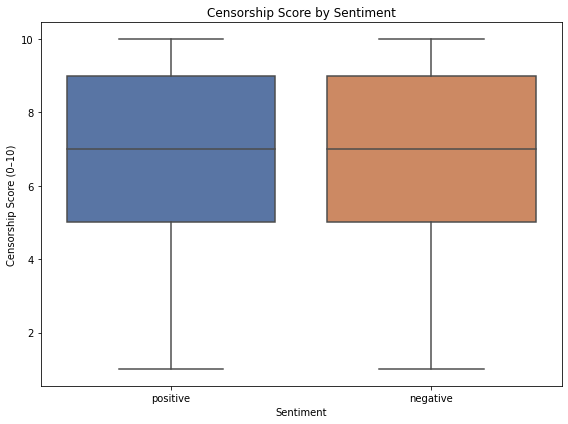

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 合并数据
df_all = pd.concat([df_XJ_update, df_HK_update, df_JB_update], ignore_index=True)

# 简单统计分析
score_summary = df_all.groupby('Sentiment_Label')['Censor_Score'].agg(['count', 'mean', 'median', 'var', 'min', 'max']).reset_index()
print(score_summary)

# 绘制箱线图
plt.figure(figsize=(8, 6))
sns.boxplot(x='Sentiment_Label', y='Censor_Score', data=df_all, palette={'positive': '#4c72b0', 'negative': '#dd8452'})
plt.title('Censorship Score by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Censorship Score (0–10)')
plt.tight_layout()

# 保存图片
#plt.savefig('sentiment_vs_censor_score.png', dpi=300)
plt.show()


In [33]:
# 中文到英文的映射
emotion_map = {
    '厌恶': 'Disgust',
    '喜欢': 'Like',
    '开心': 'Happy',
    '悲伤': 'Sad',
    '惊讶': 'Surprise',
    '生气': 'Angry',
    '害怕': 'Fear'
}

# 应用映射
df_all['Emotion_Eng'] = df_all['Emotion_Detail'].map(emotion_map)


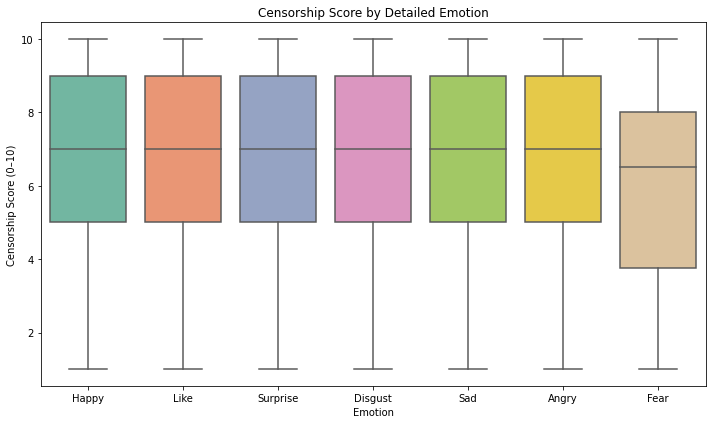

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置画图风格
plt.figure(figsize=(10, 6))
order = ['Happy', 'Like', 'Surprise', 'Disgust', 'Sad', 'Angry', 'Fear']  # 按大类逻辑排序
sns.boxplot(x='Emotion_Eng', y='Censor_Score', data=df_all, order=order, palette='Set2')

plt.title('Censorship Score by Detailed Emotion')
plt.xlabel('Emotion')
plt.ylabel('Censorship Score (0–10)')
plt.tight_layout()

# 保存图像
#plt.savefig('censor_score_by_detailed_emotion.png', dpi=300)
plt.show()


In [38]:
summary_df = df_all.groupby(['Certification_Type', 'Emotion_Eng'])['Censor_Score'].agg(
    count='count',
    mean='mean',
    median='median',
    var='var',
    min='min',
    max='max'
).reset_index()

# 保存结果为 CSV 文件以备查阅
summary_df.to_csv("certification_emotion_censorscore_summary.csv", index=False)

# 预览输出前几行
print(summary_df.head(10))


       Certification_Type Emotion_Eng  count      mean  median        var  \
0              Enterprise     Disgust      2  2.500000     2.5   0.500000   
1              Enterprise       Happy      1  6.000000     6.0        NaN   
2              Enterprise        Like      4  8.000000     8.0   3.333333   
3  Famous Content Creator       Angry    216  6.134259     6.0   6.833053   
4  Famous Content Creator     Disgust   4591  6.541712     7.0   6.457465   
5  Famous Content Creator        Fear      3  5.333333     7.0  14.333333   
6  Famous Content Creator       Happy    679  6.562592     7.0   6.334941   
7  Famous Content Creator        Like   2220  6.586036     7.0   6.306700   
8  Famous Content Creator         Sad    583  7.073756     7.0   4.188709   
9  Famous Content Creator    Surprise    220  6.577273     7.0   6.573910   

   min  max  
0    2    3  
1    6    6  
2    6   10  
3    1   10  
4    1   10  
5    1    8  
6    1   10  
7    1   10  
8    1   10  
9    1   10 

In [40]:
# 只保留样本数大于等于10的组合
summary_df_filtered = summary_df[summary_df['count'] >= 10]


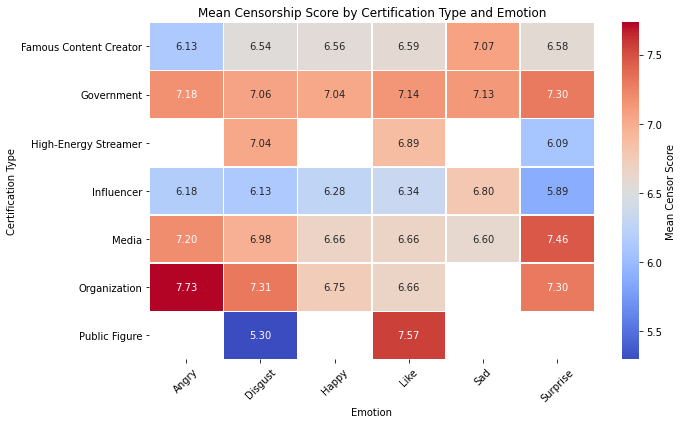

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 假设 summary_df 是你刚才生成的完整 DataFrame
summary_df_filtered = summary_df[summary_df['count'] >= 10]

# 构建透视表用于热力图：行是认证类型，列是情绪，值是 censor score 的均值
pivot_table = summary_df_filtered.pivot(index='Certification_Type',
                                         columns='Emotion_Eng',
                                         values='mean')

# 绘制热力图
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, cbar_kws={'label': 'Mean Censor Score'})
plt.title('Mean Censorship Score by Certification Type and Emotion')
plt.xlabel('Emotion')
plt.ylabel('Certification Type')
plt.xticks(rotation=45)
plt.tight_layout()

# 保存图片
plt.savefig("censor_score_heatmap.png", dpi=300)
plt.show()


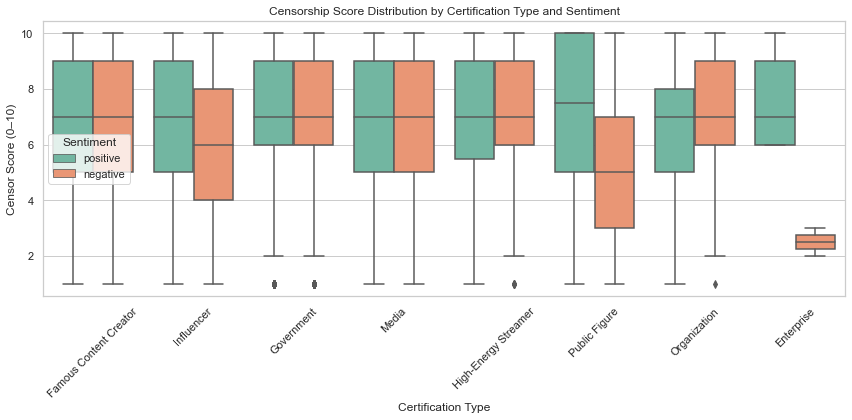

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 你本地已加载的数据：df_all_update
# 确保包含至少这些列：Certification_Type, Censor_Score, Sentiment_Label

# 筛选只包含 positive 和 negative 的数据
filtered_df = df_all[df_all["Sentiment_Label"].isin(["positive", "negative"])]

# 设置风格
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# 绘制箱线图
sns.boxplot(
    data=filtered_df,
    x="Certification_Type",
    y="Censor_Score",
    hue="Sentiment_Label",
    palette="Set2"
)

plt.title("Censorship Score Distribution by Certification Type and Sentiment")
plt.xlabel("Certification Type")
plt.ylabel("Censor Score (0–10)")
plt.xticks(rotation=45)
plt.legend(title="Sentiment")
plt.tight_layout()
#plt.savefig("censor_score_certification_sentiment.png", dpi=300)
plt.show()


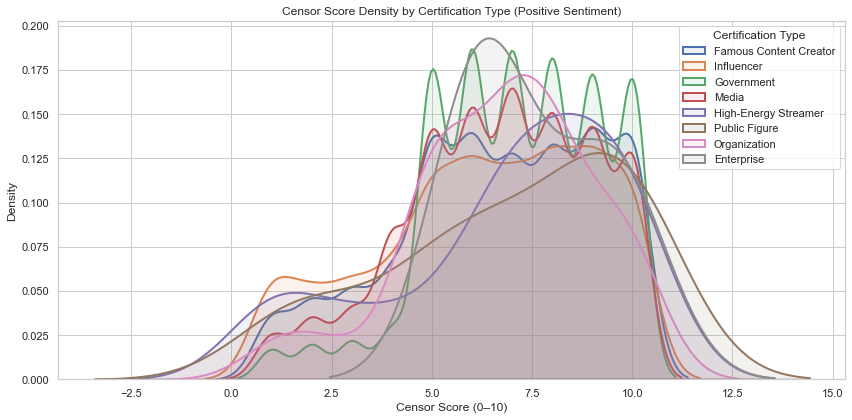

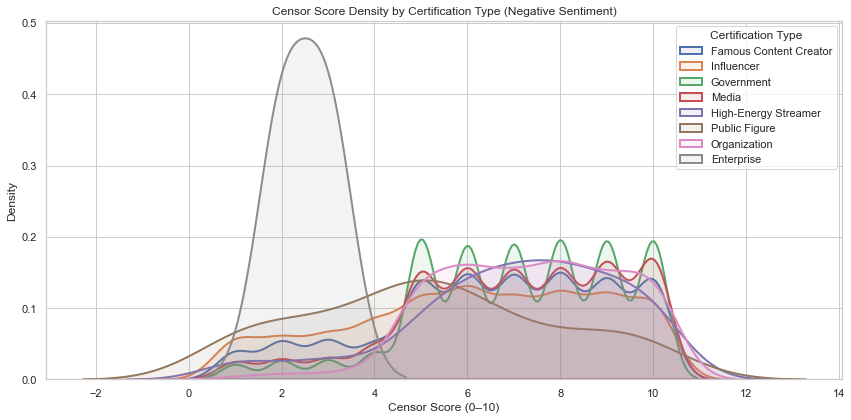

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 假设你已经加载了 df_all_update
# 并且包含：Certification_Type, Censor_Score, Sentiment_Label

# 设置绘图风格

sns.set(style="whitegrid")
df_all_update = df_all
# ---------- Positive ----------
plt.figure(figsize=(12, 6))
for cert_type in df_all_update["Certification_Type"].unique():
    subset = df_all_update[(df_all_update["Certification_Type"] == cert_type) &
                           (df_all_update["Sentiment_Label"] == "positive")]
    if not subset.empty:
        sns.kdeplot(data=subset, x="Censor_Score", label=cert_type, fill=True, alpha=0.1, linewidth=2, bw_adjust=0.9)

plt.title("Censor Score Density by Certification Type (Positive Sentiment)")
plt.xlabel("Censor Score (0–10)")
plt.ylabel("Density")
plt.legend(title="Certification Type")
plt.tight_layout()
plt.savefig("censor_score_density_positive.png", dpi=300)
plt.show()

# ---------- Negative ----------
plt.figure(figsize=(12, 6))
for cert_type in df_all_update["Certification_Type"].unique():
    subset = df_all_update[(df_all_update["Certification_Type"] == cert_type) &
                           (df_all_update["Sentiment_Label"] == "negative")]
    if not subset.empty:
        sns.kdeplot(data=subset, x="Censor_Score", label=cert_type, fill=True, alpha=0.1, linewidth=2, bw_adjust=0.9)

plt.title("Censor Score Density by Certification Type (Negative Sentiment)")
plt.xlabel("Censor Score (0–10)")
plt.ylabel("Density")
plt.legend(title="Certification Type")
plt.tight_layout()
plt.savefig("censor_score_density_negative.png", dpi=300)
plt.show()


In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# 替换 NaN 为字符串 'None'
df_all_update["Certification_Type"] = df_all_update["Certification_Type"].fillna("None")

# 获取所有认证类型
cert_types = df_all_update["Certification_Type"].unique()

# 生成图
for cert_type in cert_types:
    plt.figure(figsize=(10, 6))
    
    for sentiment in ["positive", "negative"]:
        subset = df_all_update[
            (df_all_update["Certification_Type"] == cert_type) &
            (df_all_update["Sentiment_Label"] == sentiment)
        ]
        if not subset.empty:
            sns.kdeplot(
                data=subset,
                x="Censor_Score",
                label=sentiment.capitalize(),
                fill=True,
                alpha=0.2
            )
    
    plt.title(f"Censor Score Distribution for {cert_type}")
    plt.xlabel("Censor Score (0–10)")
    plt.ylabel("Density")
    plt.legend(title="Sentiment")
    plt.tight_layout()
    
    # 安全地处理文件名
    safe_name = str(cert_type).replace(' ', '_').replace('/', '_')
    plt.savefig(f"censor_score_density_{safe_name}.png", dpi=300)
    plt.close()


In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 设置绘图风格
sns.set(style="whitegrid")

# 定义一个函数来绘制热力图
def plot_topic_heatmap(df, topic_name, filename):
    # 筛选出统计数量 >= 10 的组合
    summary_df = df.groupby(['Certification_Type', 'Emotion_Eng'])['Censor_Score'] \
                   .agg(['mean', 'count']).reset_index()
    summary_df_filtered = summary_df[summary_df['count'] >= 10]

    # 创建透视表
    pivot_table = summary_df_filtered.pivot(index='Certification_Type',
                                            columns='Emotion_Eng',
                                            values='mean')

    # 画图
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, cbar_kws={'label': 'Mean Censor Score'})
    plt.title(f'Mean Censorship Score by Certification Type and Emotion\n({topic_name})')
    plt.xlabel('Emotion')
    plt.ylabel('Certification Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.close()

# 分别绘制三张图
plot_topic_heatmap(df_HK_update, "Hong Kong Protests", "hk_cert_emotion_heatmap.png")
plot_topic_heatmap(df_XJ_update, "Xinjiang Counter-terrorism", "xj_cert_emotion_heatmap.png")
plot_topic_heatmap(df_JB_update, "China Progress", "jb_cert_emotion_heatmap.png")


In [54]:
emotion_map = {
    '厌恶': 'Disgust',
    '喜欢': 'Like',
    '开心': 'Happy',
    '悲伤': 'Sad',
    '惊讶': 'Surprise',
    '生气': 'Angry',
    '害怕': 'Fear'
}

# 应用映射
df_HK_update['Emotion_Eng'] = df_HK_update['Emotion_Detail'].map(emotion_map)
df_XJ_update['Emotion_Eng'] = df_XJ_update['Emotion_Detail'].map(emotion_map)
df_JB_update['Emotion_Eng'] = df_JB_update['Emotion_Detail'].map(emotion_map)

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# Topic & Certification 设定
topics = ['Hong Kong Protests', 'China Progress', 'Xinjiang Counter-terrorism']
cert_types = ['Government', 'Media', 'Organization', 'Famous Content Creator', 'Influencer', 'High-Energy Streamer']
columns_to_keep = ['Certification', 'View', 'Comment_num', 'Date', 'Name', 'Fans',
                   'Video_Index', 'Comment_Text', 'Censor_Score', 'Topic',
                   'Certification_Type', 'Emotion_Detail', 'Sentiment_Label']

# 合并三个 DataFrame
full_df = pd.concat([
    df_HK_update[columns_to_keep],
    df_JB_update[columns_to_keep],
    df_XJ_update[columns_to_keep]
], ignore_index=True)

for topic in topics:
    for cert in cert_types:
        df_sub = full_df[(full_df['Topic'] == topic) & (full_df['Certification_Type'] == cert)]

        # 若样本不足则跳过
        if df_sub.empty or df_sub['Sentiment_Label'].nunique() < 2:
            continue

        plt.figure(figsize=(8, 5))
        sns.kdeplot(data=df_sub[df_sub['Sentiment_Label'] == 'positive'], x='Censor_Score',
                    label='Positive', fill=True, common_norm=False, alpha=0.3)
        sns.kdeplot(data=df_sub[df_sub['Sentiment_Label'] == 'negative'], x='Censor_Score',
                    label='Negative', fill=True, common_norm=False, alpha=0.3)

        plt.title(f'Censor Score Distribution for {cert}\n({topic})')
        plt.xlabel('Censor Score (0–10)')
        plt.ylabel('Density')
        plt.legend(title='Sentiment')
        plt.tight_layout()

        # 命名为 censor_score_density_{topic}_{cert}.png
        topic_clean = topic.lower().replace(' ', '_')
        cert_clean = cert.replace(' ', '_').replace('-', '_')
        filename = f'censor_score_density_{topic_clean}_{cert_clean}.png'
        plt.savefig(filename, dpi=300)
        plt.close()
